# PBL 1

## 1. IMPORTANDO BIBLIOTECAS

In [35]:
import pandas as pd
import numpy as np #-> Um sabio disse que é sempre bom importar numpy
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. IMPORTANDO DATA FRAMES

In [36]:
# Carregar os DataFrames
client=pd.read_csv('/content/drive/MyDrive/PBL IA/customer_table.csv')#-> Informações do cliente
date=pd.read_csv('/content/drive/MyDrive/PBL IA/date_table.csv')#-> Análise temporal das sessões e abandonos ao longo do tempo
device=pd.read_csv('/content/drive/MyDrive/PBL IA/device_table.csv')#-> Legenda de dispositivos e sitemas operacionais
product=pd.read_csv('/content/drive/MyDrive/PBL IA/product_table.csv')#-> informações sobre os produtos que são vendidos na loja online.
fact=pd.read_csv('/content/drive/MyDrive/PBL IA/fact_table.csv')#-> Registra cada sessão de compra de um produto

## 3. LEITURA DA BASE DE DADOS VERIFICAÇÃO DE TIPAGEM

### CLIENT

In [37]:
display(client.head())

,customer_id,customer_name,age,gender,city
0,1,Customer 1,49,Female,London
1,2,Customer 2,45,Male,London
2,3,Customer 3,51,Male,London
3,4,Customer 4,38,Male,New York
4,5,Customer 5,26,Male,London


In [38]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    1000 non-null   int64 
 1   customer_name  1000 non-null   object
 2   age            1000 non-null   int64 
 3   gender         1000 non-null   object
 4   city           1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


### DATE

In [39]:
display(date.head())

,date_id,date
0,1,1/1/2023
1,2,1/2/2023
2,3,1/3/2023
3,4,1/4/2023
4,5,1/5/2023


In [40]:
date.info()#-> Erro: coluna "date" com erro de tipagem

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date_id  366 non-null    int64 
 1   date     366 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


### DEVICE

In [41]:
display(device.head())

,device_id,device_type,os
0,1,Tablet,iOS
1,2,Desktop,iOS
2,3,Mobile,Windows
3,4,Mobile,Android
4,5,Tablet,iOS


In [42]:
device.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   device_id    5 non-null      int64 
 1   device_type  5 non-null      object
 2   os           5 non-null      object
dtypes: int64(1), object(2)
memory usage: 252.0+ bytes


### PRODUCT

In [43]:
display(product.head())

,product_id,product_name,category,price
0,1,Laptop,Electronics,1026.94
1,2,Smartphone,Electronics,641.94
2,3,Headphones,Electronics,866.21
3,4,Smartwatch,Electronics,1221.77
4,5,Camera,Electronics,1290.76


In [44]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    25 non-null     int64  
 1   product_name  25 non-null     object 
 2   category      25 non-null     object 
 3   price         25 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 932.0+ bytes


### FACT

In [45]:
fact.head()

,session_id,customer_id,product_id,device_id,date_id,quantity,abandonment_time
0,1,979,20,5,252,4,7/13/2023
1,2,373,12,3,353,2,11/7/2023
2,3,32,3,4,286,2,3/3/2023
3,4,631,25,1,365,2,NaN
4,5,127,9,3,163,3,7/22/2023


In [46]:
fact.info() #-> Erro: coluna "abandonment_time" com erro de tipagem e "NaN"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   session_id        5000 non-null   int64 
 1   customer_id       5000 non-null   int64 
 2   product_id        5000 non-null   int64 
 3   device_id         5000 non-null   int64 
 4   date_id           5000 non-null   int64 
 5   quantity          5000 non-null   int64 
 6   abandonment_time  2524 non-null   object
dtypes: int64(6), object(1)
memory usage: 273.6+ KB


In [47]:
# 1. Completude: Verificar valores faltantes
print("\nFact Table:\n", fact.isnull().sum())


Fact Table:
 session_id             0
customer_id            0
product_id             0
device_id              0
date_id                0
quantity               0
abandonment_time    2476
dtype: int64


Análise:
- 2524 de produtos cancelados
- 2476 de produtos comprados


## 4. TRATAMENTO DE DADOS

In [48]:
date['date'] = pd.to_datetime(date['date'])

In [49]:
fact['abandonment_time'] = pd.to_datetime(fact['abandonment_time'])
pd.to_datetime(fact['abandonment_time'],errors = 'coerce')

,abandonment_time
0,2023-07-13
1,2023-11-07
2,2023-03-03
3,NaT
4,2023-07-22
...,...
4995,NaT
4996,NaT
4997,2023-03-05
4998,NaT


## 5. ANÁLISE INICIAL

In [50]:
print("Data incial:", date['date'].min())
print("Data final:", date['date'].max())
print("Abrangencia:",date.shape[0])

Data incial: 2023-01-01 00:00:00
Data final: 2024-01-01 00:00:00
Abrangencia: 366


In [51]:
print(client.value_counts('city'))

city
Sydney      213
New York    209
Berlin      206
London      187
Mumbai      185
Name: count, dtype: int64


## 6. ANÁLISE DE DADOS

In [52]:
import pandas as pd
import plotly.express as px

# Remover valores nulos e criar uma cópia do DataFrame
abandono_data = fact.dropna(subset=['abandonment_time']).copy()

# Garantir que 'abandonment_time' seja datetime
abandono_data['abandonment_time'] = pd.to_datetime(abandono_data['abandonment_time'], errors='coerce')

# Extrair o mês do abandono
abandono_data['abandonment_month'] = abandono_data['abandonment_time'].dt.month

# Criar um dicionário para mapear números dos meses para nomes
meses_dict = {
    1: "Janeiro", 2: "Fevereiro", 3: "Março", 4: "Abril",
    5: "Maio", 6: "Junho", 7: "Julho", 8: "Agosto",
    9: "Setembro", 10: "Outubro", 11: "Novembro", 12: "Dezembro"
}

# Contar abandonos por mês
abandono_mes = abandono_data['abandonment_month'].value_counts().sort_index()

# Converter índice para os nomes dos meses
abandono_mes.index = abandono_mes.index.map(meses_dict)

# Criar um gráfico de barras interativo com Plotly
fig = px.bar(
    abandono_mes,
    x=abandono_mes.index,
    y=abandono_mes.values,
    text=abandono_mes.values,
    labels={'x': 'Mês', 'y': 'Número de Carrinhos Abandonados'},
    title="Número de Carrinhos Abandonados por Mês",
    color=abandono_mes.values,
    color_continuous_scale="Blues"
)

# Ajustes no layout
fig.update_traces(textposition="outside")
fig.update_layout(xaxis_title="Mês", yaxis_title="Carrinhos Abandonados", template="plotly_white")

# Mostrar o gráfico
fig.show()


In [53]:
# Mesclar os dados de dispositivos com os dados principais
fact_device = pd.merge(fact, device, on='device_id', how='left')

# Contar abandonos por tipo de dispositivo
fact_device_count = fact_device.groupby('device_type')['abandonment_time'].count().reset_index()

# Criar um gráfico de barras interativo com Plotly
fig = px.bar(
    fact_device_count,
    x='device_type',
    y='abandonment_time',
    text='abandonment_time',
    labels={'device_type': 'Tipo de Dispositivo', 'abandonment_time': 'Sessões Abandonadas'},
    title="Abandono de Carrinho por Tipo de Dispositivo",
    color='abandonment_time',
    color_continuous_scale="Blues"
)

# Ajustes visuais
fig.update_traces(textposition="outside")
fig.update_layout(
    xaxis_title="Tipo de Dispositivo",
    yaxis_title="Número de Sessões Abandonadas",
    template="plotly_white"
)

# Mostrar o gráfico
fig.show()


In [54]:
import pandas as pd
import plotly.express as px


fact_client = fact.merge(client, on='customer_id', how='left')

# Definir as faixas etárias
bins = [0, 18, 25, 35, 45, 55, 100]
labels = ['<18', '19-25', '26-35', '36-45', '46-55', '56+']

# Criar a coluna de faixa etária
fact_client['age_group'] = pd.cut(fact_client['age'], bins=bins, labels=labels, right=False)

# Contar abandonos por faixa etária
abandonment_by_age_group = fact_client.groupby('age_group')['abandonment_time'].count().reset_index()

# Criar o gráfico de barras interativo
fig = px.bar(
    abandonment_by_age_group,
    x='age_group',
    y='abandonment_time',
    text='abandonment_time',
    labels={'age_group': 'Faixa Etária', 'abandonment_time': 'Sessões Abandonadas'},
    title="Abandono de Carrinho por Faixa Etária",
    color='abandonment_time',
    color_continuous_scale="Blues"
)

# Ajustes visuais
fig.update_traces(textposition="outside")
fig.update_layout(
    xaxis_title="Faixa Etária",
    yaxis_title="Número de Sessões Abandonadas",
    template="plotly_white"
)

# Mostrar o gráfico
fig.show()


<ipython-input-54-43d95297fd62>:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Merge fact_df com date_df para adicionar a coluna 'date' (data da sessão/compra)
fact_date_df = pd.merge(fact, date, on='date_id', how='left')

# Remover linhas onde 'abandonment_time' é nulo (focando apenas em sessões abandonadas)
abandonment_time_diff_df = fact_date_df.dropna(subset=['abandonment_time']).copy()

# Garantir que as colunas de data sejam do tipo datetime
abandonment_time_diff_df['date'] = pd.to_datetime(abandonment_time_diff_df['date'])
abandonment_time_diff_df['abandonment_time'] = pd.to_datetime(abandonment_time_diff_df['abandonment_time'])

# Calcular a diferença de tempo entre sessão e abandono
abandonment_time_diff_df['time_difference'] = abandonment_time_diff_df['abandonment_time'] - abandonment_time_diff_df['date']

# Converter a diferença para horas
abandonment_time_diff_df['time_difference_hours'] = abandonment_time_diff_df['time_difference'].dt.total_seconds() / 3600

# Remover valores negativos, caso existam
abandonment_time_diff_df = abandonment_time_diff_df[abandonment_time_diff_df['time_difference_hours'] >= 0]

# Estatísticas descritivas
stats = abandonment_time_diff_df['time_difference_hours'].describe()
print("\n📊 Estatísticas Descritivas da Diferença de Tempo (Horas):\n")
print(stats.to_string(float_format='%.2f'))  # Formatando para 2 casas decimais

# Limite superior para o gráfico (removendo outliers extremos)
q95 = abandonment_time_diff_df['time_difference_hours'].quantile(0.95)

# Criar histograma interativo com Plotly
fig = px.histogram(
    abandonment_time_diff_df,
    x='time_difference_hours',
    nbins=50,
    title="Distribuição do Tempo entre Sessão e Abandono",
    labels={'time_difference_hours': 'Diferença de Tempo (Horas)', 'count': 'Frequência'},
    color_discrete_sequence=['skyblue']
)

# Ajustar limites do eixo X para remover outliers extremos
fig.update_xaxes(range=[0, q95])

# Melhorar layout do gráfico
fig.update_layout(
    bargap=0.05,
    xaxis_title="Diferença de Tempo (Horas)",
    yaxis_title="Número de Sessões Abandonadas",
    template="plotly_white"
)

# Mostrar gráfico interativo
fig.show()



📊 Estatísticas Descritivas da Diferença de Tempo (Horas):

count   1279.00
mean    2879.79
std     2075.46
min        0.00
25%     1104.00
50%     2544.00
75%     4272.00
max     8736.00


## PREDIÇÃO

In [64]:
# criar flag 'is_abandoned'
fact['is_abandoned'] = fact['abandonment_time'].notna().astype(int)

# Juntar a tabela de fatos com outras tabelas para enriquecer os dados
merged_df = pd.merge(fact, client, on='customer_id', how='left')
merged_df = pd.merge(merged_df, product, on='product_id', how='left')
merged_df = pd.merge(merged_df, device, on='device_id', how='left')
merged_df = pd.merge(merged_df, date, on='date_id', how='left')

#Engenharia de atributos - Extrair mês e dia da semana da data.
merged_df['month'] = merged_df['date'].dt.month
merged_df['day_of_week'] = merged_df['date'].dt.day_name()

#  Lidar com variáveis categóricas usando codificação one-hot
categorical_cols = ['gender', 'city', 'device_type', 'os', 'category', 'day_of_week']
merged_df = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=True)

In [57]:
# Parte 3: Preparação dos Dados para Modelagem

# Preparar data para modelagem - Selecionar features relevantes e lidar com valores faltantes
feature_cols = ['quantity', 'price', 'age'] + [col for col in merged_df.columns if col.startswith(('gender_', 'city_', 'device_type_', 'os_', 'category_', 'day_of_week_'))]
X = merged_df[feature_cols].fillna(merged_df[feature_cols].mean()) # Preencher NaN com a média para simplificar
y_regression = fact['quantity'] # Exemplo de alvo para regressão (pode ser ajustado)
y_classification = fact['is_abandoned']

# Dividir dados em conjuntos de treinamento e teste
X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(X, y_classification, y_regression, test_size=0.2, random_state=42)


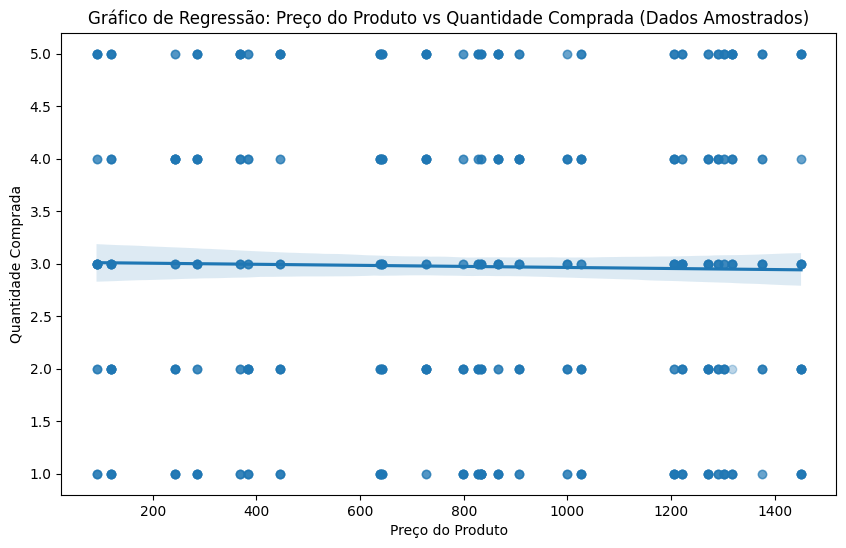

In [58]:
# Parte 4: Gráfico de Regressão

plt.figure(figsize=(10, 6))
sns.regplot(x='price', y='quantity', data=merged_df.sample(1000), scatter_kws={'alpha':0.3})
plt.title('Gráfico de Regressão: Preço do Produto vs Quantidade Comprada (Dados Amostrados)')
plt.xlabel('Preço do Produto')
plt.ylabel('Quantidade Comprada')
plt.show()

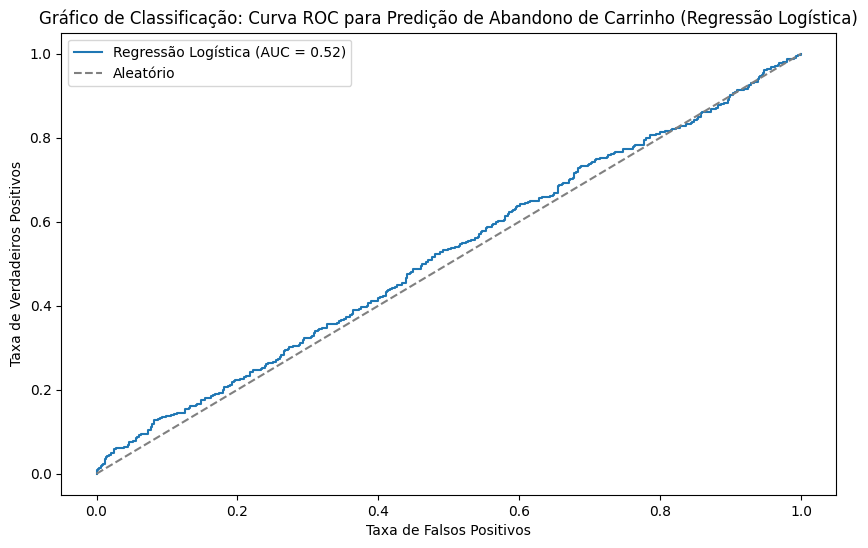

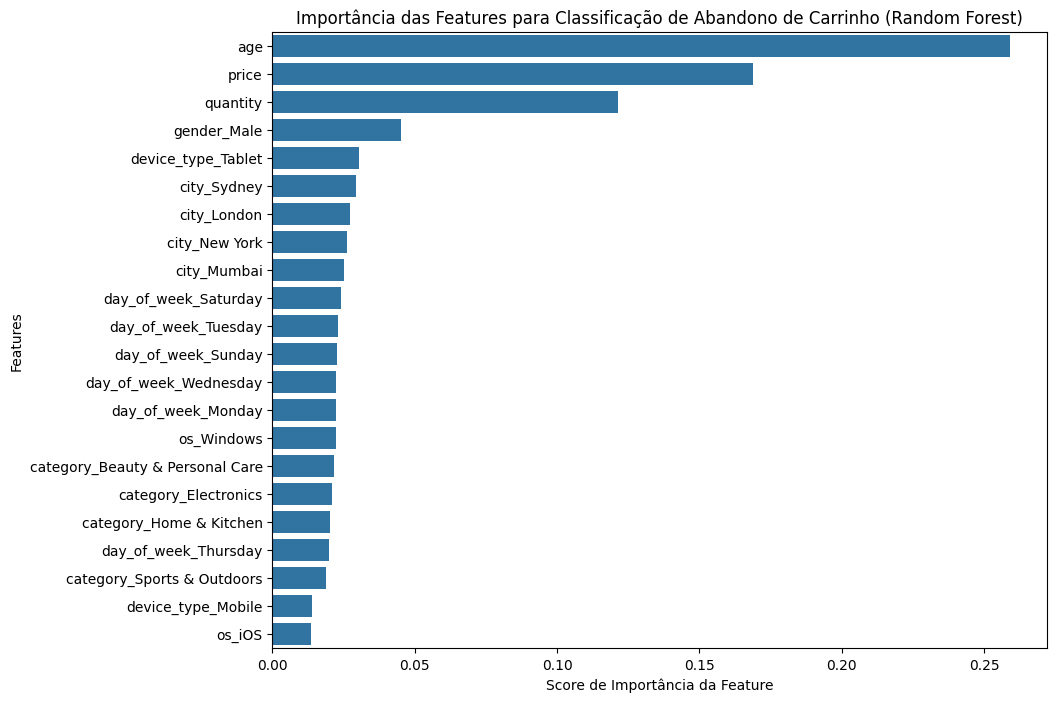

In [59]:
# Parte 5: Gráfico de Classificação (Regressão Logística)

# Gráfico de Classificação (Regressão Logística - para predição de abandono de carrinho).
model_logistic = LogisticRegression(max_iter=1000)
model_logistic.fit(X_train, y_train_class)
y_pred_proba_logistic = model_logistic.predict_proba(X_test)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test_class, y_pred_proba_logistic)
auc_logistic = roc_auc_score(y_test_class, y_pred_proba_logistic)

plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic, label=f'Regressão Logística (AUC = {auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Gráfico de Classificação: Curva ROC para Predição de Abandono de Carrinho (Regressão Logística)')
plt.legend()
plt.show()

# Importância das Features para Classificação de Abandono de Carrinho (Random Forest):
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train_class)

feature_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Score de Importância da Feature')
plt.ylabel('Features')
plt.title("Importância das Features para Classificação de Abandono de Carrinho (Random Forest)")
plt.show()


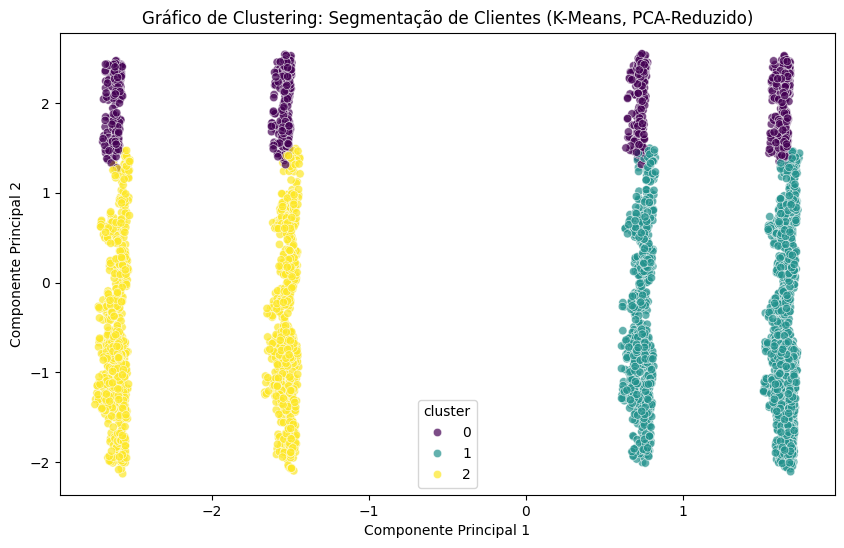

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


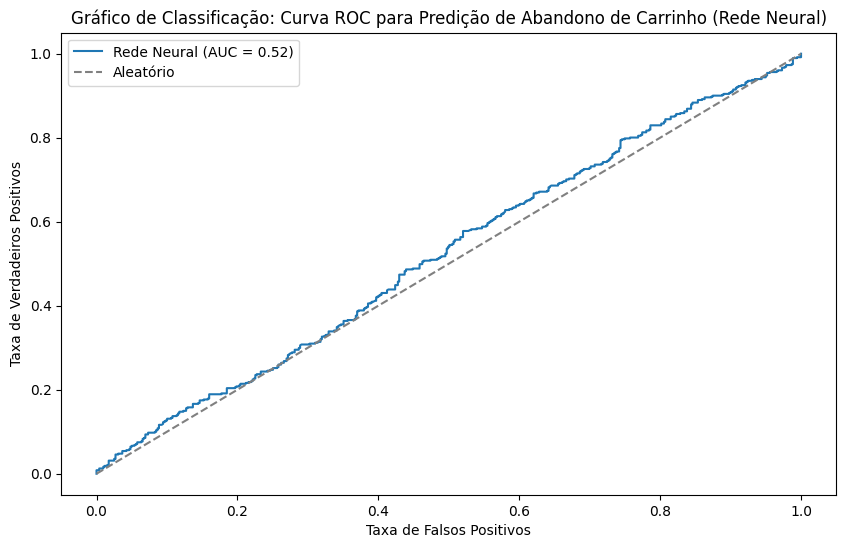

dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


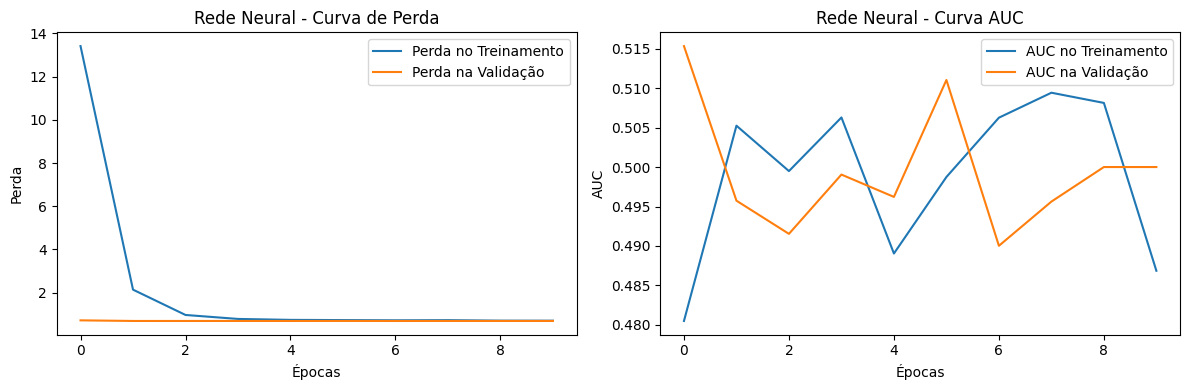

In [71]:
# Gráfico de Clustering (Clustering K-Means - em segmentos de clientes
features_clustering = merged_df[['age', 'price', 'quantity'] + [col for col in merged_df.columns if col.startswith(('gender_', 'city_', 'device_type_', 'os_', 'category_'))]].fillna(merged_df[['age', 'price', 'quantity']].mean())
scaler = StandardScaler()
X_scaled_clustering = scaler.fit_transform(features_clustering)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
merged_df['cluster'] = kmeans.fit_predict(X_scaled_clustering)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled_clustering)
pca_df = pd.DataFrame(data = principalComponents, columns = ['componente principal 1', 'componente principal 2'])
pca_df['cluster'] = merged_df['cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='componente principal 1', y='componente principal 2', hue='cluster', data=pca_df, palette='viridis', alpha=0.7)
plt.title('Gráfico de Clustering: Segmentação de Clientes (K-Means, PCA-Reduzido)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

model_nn = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid') # Sigmoid para classificação binária
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='AUC')]) # Métrica AUC para classificação - Alterado aqui!

history = model_nn.fit(X_train, y_train_class, epochs=10, batch_size=32, validation_split=0.2, verbose=0) # Redução de épocas para execução rápida

y_pred_proba_nn = model_nn.predict(X_test).flatten()
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test_class, y_pred_proba_nn)
auc_nn = auc(fpr_nn, tpr_nn)


plt.figure(figsize=(10, 6))
plt.plot(fpr_nn, tpr_nn, label=f'Rede Neural (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Gráfico de Classificação: Curva ROC para Predição de Abandono de Carrinho (Rede Neural)')
plt.legend(title='Legenda')
plt.show()

# Curvas de Perda e AUC durante o treinamento (Rede Neural)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda no Treinamento')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.title('Rede Neural - Curva de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(title='Legenda')

plt.subplot(1, 2, 2)
print(history.history.keys()) # para verificar as chaves disponíveis
plt.plot(history.history['AUC'], label='AUC no Treinamento') # Use 'AUC' em maiúsculo
plt.plot(history.history['val_AUC'], label='AUC na Validação') # Use 'val_AUC' em maiúsculo
plt.title('Rede Neural - Curva AUC')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend(title='Legenda')
plt.tight_layout()
plt.show()


--- Análise de Regressão ---
              precision    recall  f1-score   support

           0       0.51      0.45      0.48       495
           1       0.51      0.56      0.54       505

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000



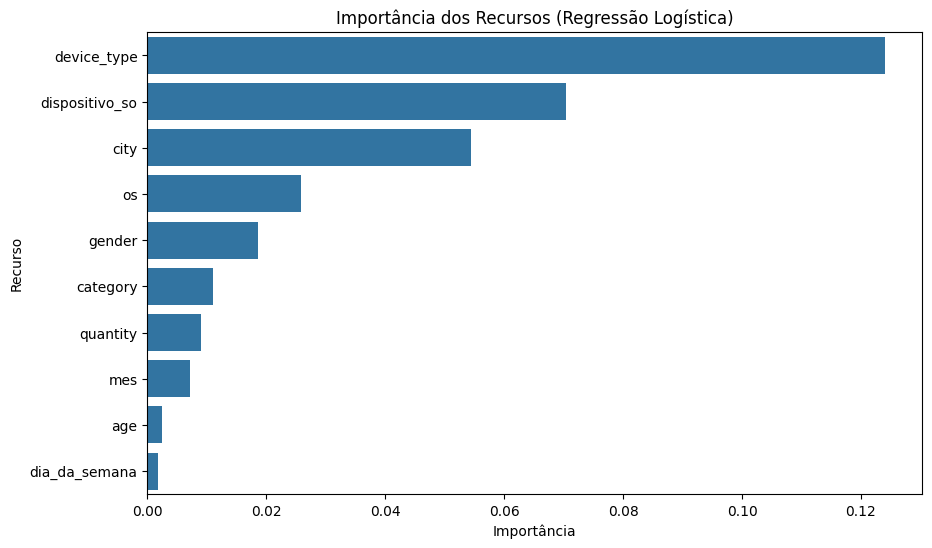


--- Análise de Classificação ---
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       495
           1       0.50      0.48      0.49       505

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000



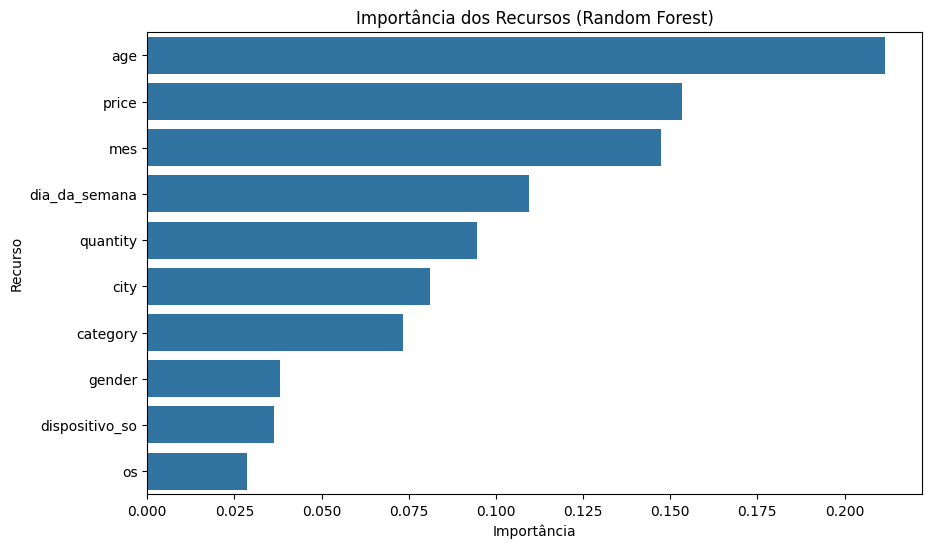


--- Análise de Clusterização ---

Análise de Cluster:
   cluster  taxa_abandono_media  idade_media  preco_medio
0        0             0.499510    40.904016   811.786827
1        1             0.504210    41.179792   824.458083
2        2             0.508163    41.172959   835.039714


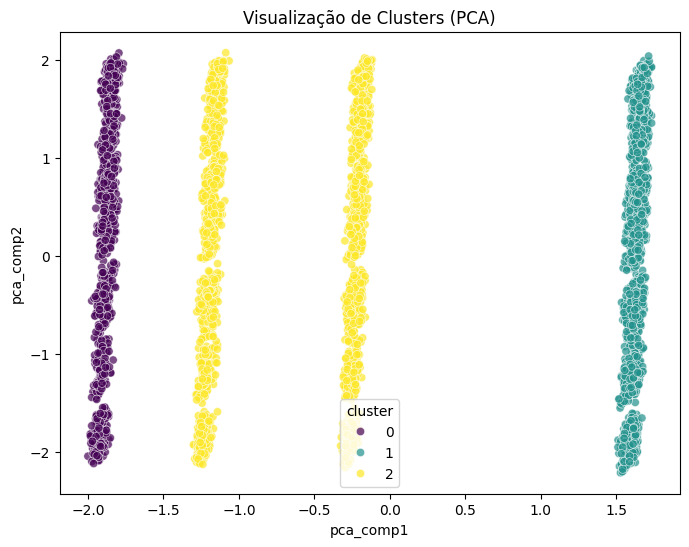


--- Análise de Rede Neural ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Acurácia da Rede Neural: 0.4990


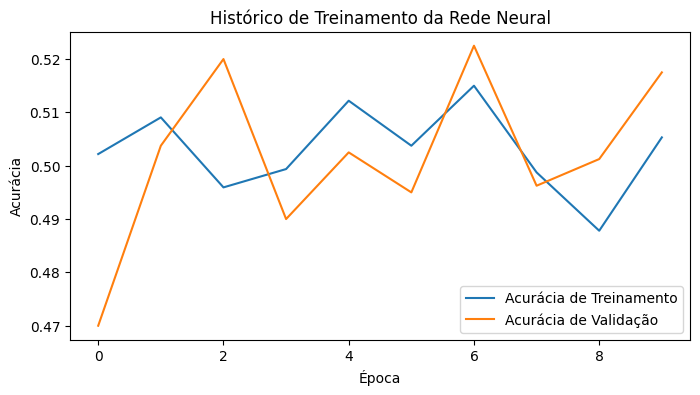


--- Resumo das Insights ---
Com base na Regressão Logística e Random Forest, os recursos mais importantes parecem estar relacionados a:
- device_type
- dispositivo_so
- city
e
- age
- price
- mes

análise de cluster mostra diferentes segmentos de clientes com taxas de abandono variáveis.
A rede neural fornece uma precisão preditiva de 0.4990.

Possíveis razões para abandono de carrinho com base na análise:
- Recursos como 'price', 'quantity' e potencialmente 'device_type', 'os', 'category', 'demografia do cliente' são preditores importantes de abandono de carrinho.
- A segmentação de clientes usando clusterização revela grupos com diferentes propensidades a abandonar carrinhos, sugerindo que estratégias personalizadas podem ser eficazes.


In [70]:
# Mesclar tabela de fatos com outras tabelas
df = pd.merge(fact, client, on='customer_id', how='left')
df = pd.merge(df, device, on='device_id', how='left')
df = pd.merge(df, date, on='date_id', how='left')
df = pd.merge(df, product, on='product_id', how='left')

# Criar variável alvo binária para abandono de carrinho
df['is_abandoned'] = df['abandonment_time'].notna().astype(int)

# Engenharia de Recursos - Recursos Temporais
df['session_date'] = pd.to_datetime(df['date'])
df['mes'] = df['session_date'].dt.month
df['dia_da_semana'] = df['session_date'].dt.dayofweek # Segunda=0, Domingo=6

# Engenharia de Recursos - Interação Dispositivo e SO (exemplo - pode ser melhorado)
df['dispositivo_so'] = df['device_type'] + '_' + df['os']

# Codificar recursos categóricos
recursos_categoricos = ['device_type', 'os', 'gender', 'city', 'category', 'dispositivo_so']
le = LabelEncoder()
for col in recursos_categoricos:
    df[col] = le.fit_transform(df[col])

recursos_numericos = ['age', 'quantity', 'price', 'mes', 'dia_da_semana']
recursos = recursos_categoricos + recursos_numericos
X = df[recursos]
y = df['is_abandoned']

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Análise de Regressão ---
print("\n--- Análise de Regressão ---")
modelo_lr = LogisticRegression(max_iter=1000)
modelo_lr.fit(X_treino, y_treino)
y_pred_lr = modelo_lr.predict(X_teste)

print(classification_report(y_teste, y_pred_lr))

# Importância dos Recursos (Regressão)
importancia_recursos_lr = pd.DataFrame({'Recurso': X.columns, 'Importância': np.abs(modelo_lr.coef_[0])})
importancia_recursos_lr = importancia_recursos_lr.sort_values(by='Importância', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Recurso', data=importancia_recursos_lr.head(10))
plt.title('Importância dos Recursos (Regressão Logística)')
plt.xlabel('Importância')
plt.ylabel('Recurso')
plt.show()


# Análise de Classificação
print("\n--- Análise de Classificação ---")
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_treino, y_treino)
y_pred_rf = modelo_rf.predict(X_teste)

print(classification_report(y_teste, y_pred_rf))

# Importância dos Recursos (Random Forest)
importancia_recursos_rf = pd.DataFrame({'Recurso': X.columns, 'Importância': modelo_rf.feature_importances_})
importancia_recursos_rf = importancia_recursos_rf.sort_values(by='Importância', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Recurso', data=importancia_recursos_rf.head(10))
plt.title('Importância dos Recursos (Random Forest)')
plt.xlabel('Importância')
plt.ylabel('Recurso')
plt.show()


# Análise de Clusterização
print("\n--- Análise de Clusterização ---")
escalador = StandardScaler()
X_escalado = escalador.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # assumindo 3 clusters
df['cluster'] = kmeans.fit_predict(X_escalado)

# Analisar clusters
analise_cluster = df.groupby('cluster').agg(
    taxa_abandono_media=('is_abandoned', 'mean'),
    idade_media=('age', 'mean'),
    preco_medio=('price', 'mean')
).reset_index()
print("\nAnálise de Cluster:")
print(analise_cluster)

# Visualizar Clusters (usando PCA para redução de dimensionalidade para visualização)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_escalado)
df['pca_comp1'] = X_pca[:, 0]
df['pca_comp2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca_comp1', y='pca_comp2', hue='cluster', data=df, palette='viridis', alpha=0.7)
plt.title('Visualização de Clusters (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()


# Análise de Rede Neural
print("\n--- Análise de Rede Neural ---")
modelo_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(recursos)]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Sigmoide para classificação binária
])

modelo_nn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

historico = modelo_nn.fit(X_treino, y_treino, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
_, acuracia = modelo_nn.evaluate(X_teste, y_teste, verbose=0)
print(f'Acurácia da Rede Neural: {acuracia:.4f}')

# Visualizar histórico de treinamento
plt.figure(figsize=(8, 4))
plt.plot(historico.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(historico.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Histórico de Treinamento da Rede Neural')
plt.show()

# Resumo das Insights
print("\n--- Resumo das Insights ---")
print("Com base na Regressão Logística e Random Forest, os recursos mais importantes parecem estar relacionados a:")
for recurso in importancia_recursos_lr['Recurso'].head(3):
    print(f"- {recurso}")
print("e")
for recurso in importancia_recursos_rf['Recurso'].head(3):
    print(f"- {recurso}")
print("\nanálise de cluster mostra diferentes segmentos de clientes com taxas de abandono variáveis.")
print("A rede neural fornece uma precisão preditiva de {:.4f}.".format(acuracia))

print("\nPossíveis razões para abandono de carrinho com base na análise:")
print("- Recursos como 'price', 'quantity' e potencialmente 'device_type', 'os', 'category', 'demografia do cliente' são preditores importantes de abandono de carrinho.")
print("- A segmentação de clientes usando clusterização revela grupos com diferentes propensidades a abandonar carrinhos, sugerindo que estratégias personalizadas podem ser eficazes.")

Métricas de desempenho


--- Regression Analysis ---
              precision    recall  f1-score   support

           0       0.51      0.45      0.48       495
           1       0.51      0.56      0.54       505

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000



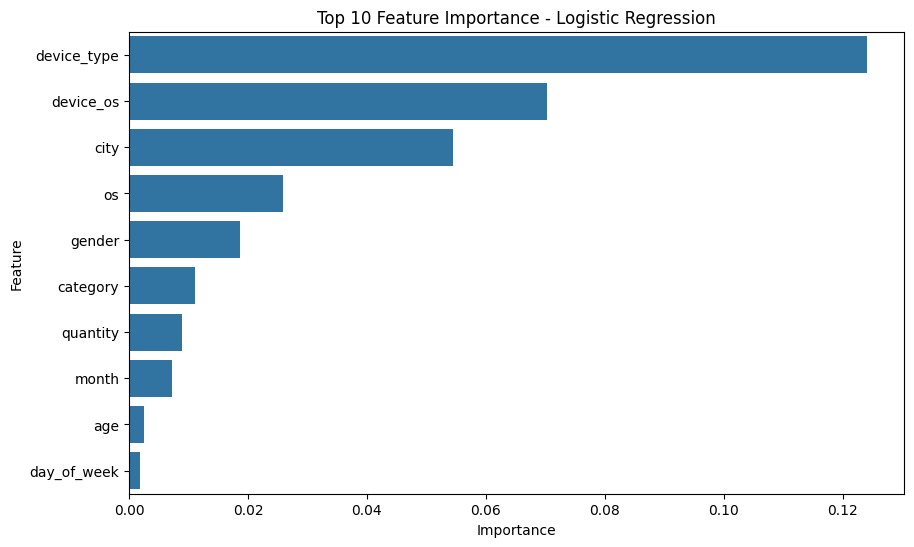


--- Classification Analysis ---
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       495
           1       0.50      0.48      0.49       505

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000



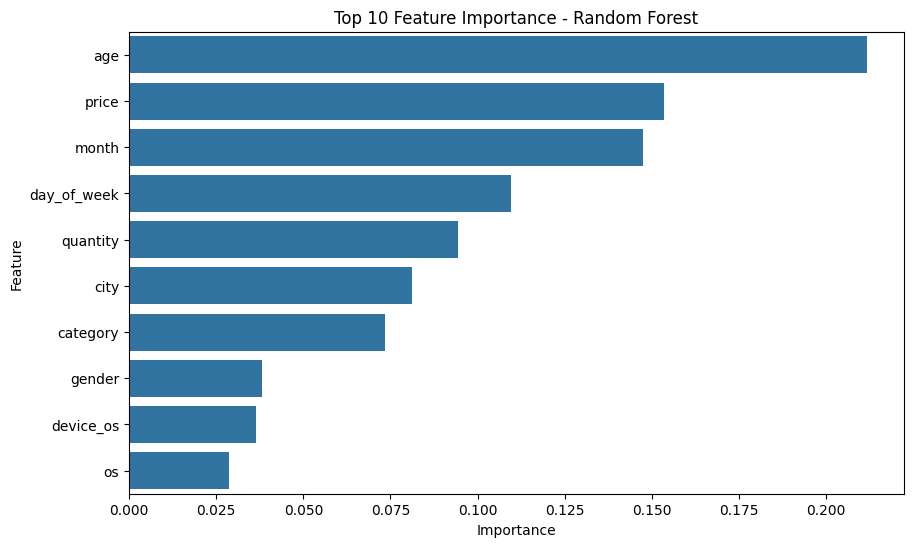


--- Clustering Analysis ---

Cluster Analysis:
   cluster  avg_abandonment_rate    avg_age   avg_price
0        0              0.499510  40.904016  811.786827
1        1              0.504210  41.179792  824.458083
2        2              0.508163  41.172959  835.039714


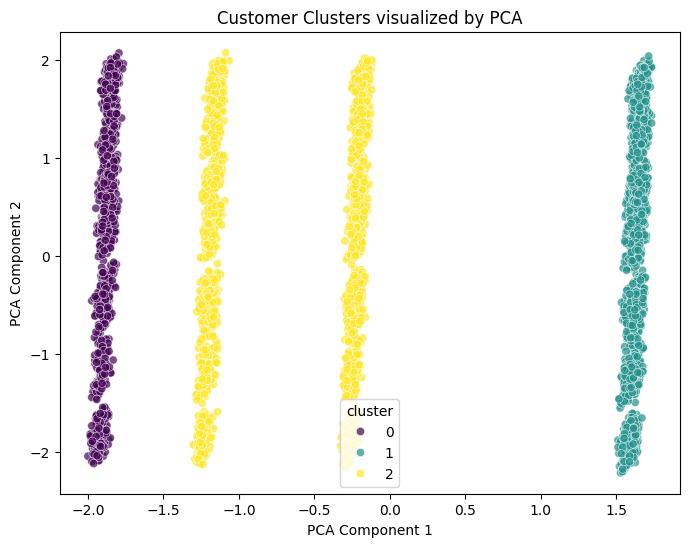


--- Neural Network Analysis ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Neural Network Accuracy: 0.5000


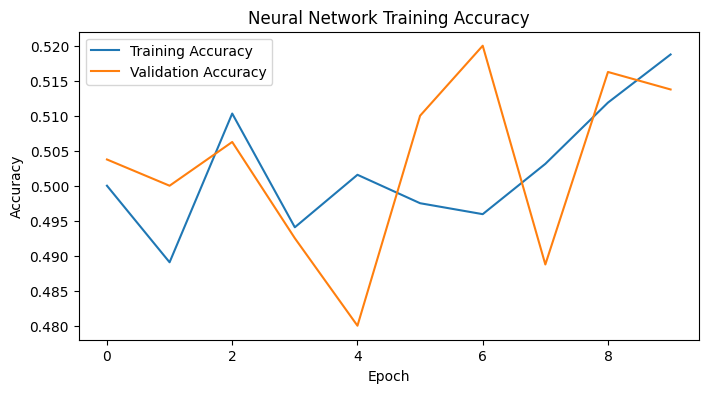


--- Summary of Insights ---
Based on Logistic Regression and Random Forest, the most important features seem to be related to:
- device_type
- device_os
- city
and
- age
- price
- month

Cluster analysis shows different segments of customers with varying abandonment rates.
Neural Network provides a predictive accuracy of 0.5000.


In [66]:
# Mesclar tabela de fatos com outras tabelas
df = pd.merge(fact, client, on='customer_id', how='left')
df = pd.merge(df, device, on='device_id', how='left')
df = pd.merge(df, date, on='date_id', how='left')
df = pd.merge(df, product, on='product_id', how='left')

# Criar variável alvo binária para abandono de carrinho
df['is_abandoned'] = df['abandonment_time'].notna().astype(int)

# Engenharia de Recursos - Recursos Temporais
df['session_date'] = pd.to_datetime(df['date'])
df['mes'] = df['session_date'].dt.month
df['dia_da_semana'] = df['session_date'].dt.dayofweek # Segunda=0, Domingo=6

# Engenharia de Recursos - Interação Dispositivo e SO
df['dispositivo_so'] = df['device_type'] + '_' + df['os']

# Codificar recursos categóricos
recursos_categoricos = ['device_type', 'os', 'gender', 'city', 'category', 'dispositivo_so']
le = LabelEncoder()
for col in recursos_categoricos:
    df[col] = le.fit_transform(df[col])

recursos_numericos = ['age', 'quantity', 'price', 'mes', 'dia_da_semana']
recursos = recursos_categoricos + recursos_numericos
X = df[recursos]
y = df['is_abandoned']

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Análise de Regressão
print("\n--- Análise de Regressão ---")
modelo_lr = LogisticRegression(max_iter=1000)
modelo_lr.fit(X_treino, y_treino)
y_pred_lr = modelo_lr.predict(X_teste)

print(classification_report(y_teste, y_pred_lr))

# Importância dos Recursos (Regressão)
importancia_recursos_lr = pd.DataFrame({'Recurso': X.columns, 'Importância': np.abs(modelo_lr.coef_[0])})
importancia_recursos_lr = importancia_recursos_lr.sort_values(by='Importância', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Recurso', data=importancia_recursos_lr.head(10))
plt.title('Top 10 Importância dos Recursos - Regressão Logística')
plt.xlabel('Importância')
plt.ylabel('Recurso')
plt.show()


# Análise de Classificação
print("\n--- Análise de Classificação ---")
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_treino, y_treino)
y_pred_rf = modelo_rf.predict(X_teste)

print(classification_report(y_teste, y_pred_rf))

# Importância dos Recursos (Random Forest)
importancia_recursos_rf = pd.DataFrame({'Recurso': X.columns, 'Importância': modelo_rf.feature_importances_})
importancia_recursos_rf = importancia_recursos_rf.sort_values(by='Importância', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Recurso', data=importancia_recursos_rf.head(10))
plt.title('Top 10 Importância dos Recursos - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Recurso')
plt.show()


# Análise de Clusterização
print("\n--- Análise de Clusterização ---")
escalador = StandardScaler()
X_escalado = escalador.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Vamos assumir 3 clusters
df['cluster'] = kmeans.fit_predict(X_escalado)

# Analisar clusters (exemplo - pode ser mais detalhado)
analise_cluster = df.groupby('cluster').agg(
    taxa_abandono_media=('is_abandoned', 'mean'),
    idade_media=('age', 'mean'),
    preco_medio=('price', 'mean')
).reset_index()
print("\nAnálise de Cluster:")
print(analise_cluster)

# Visualizar Clusters (usando PCA para redução de dimensionalidade para visualização)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_escalado)
df['pca_comp1'] = X_pca[:, 0]
df['pca_comp2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca_comp1', y='pca_comp2', hue='cluster', data=df, palette='viridis', alpha=0.7)
plt.title('Clusters de Clientes Visualizados por PCA')
plt.xlabel('Componente PCA 1')
plt.ylabel('Componente PCA 2')
plt.show()


# Análise de Rede Neural
print("\n--- Análise de Rede Neural ---")
modelo_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(recursos)]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Sigmoide para classificação binária
])

modelo_nn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

historico = modelo_nn.fit(X_treino, y_treino, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
_, acuracia = modelo_nn.evaluate(X_teste, y_teste, verbose=0)
print(f'Acurácia da Rede Neural: {acuracia:.4f}')

# Visualizar histórico de treinamento
plt.figure(figsize=(8, 4))
plt.plot(historico.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(historico.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia de Treinamento da Rede Neural')
plt.show()

# Resumo das Insights
print("\n--- Resumo das Insights ---")
print("Com base na Regressão Logística e Random Forest, os recursos mais importantes parecem estar relacionados a:")
for recurso in importancia_recursos_lr['Recurso'].head(3):
    print(f"- {recurso}")
print("e")
for recurso in importancia_recursos_rf['Recurso'].head(3):
    print(f"- {recurso}")
print("\nA análise de cluster mostra diferentes segmentos de clientes com taxas de abandono variáveis.")
print("A Rede Neural fornece uma precisão preditiva de {:.4f}.".format(acuracia))